## Half-width Uniform Disorder MC Integrator

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Parámetros
NMCS = 10**8   # Número de muestras (puedes aumentar o disminuir según tus recursos)
NBINS = 50
deltas = [0.2, 0.5, 0.9]
a = [None]*3
y = [None]*3
v = [None]*3
s = [None]*3


for i in range(0,3):  
    # Generación de datos Monte Carlo usando vectorización
    rng = np.random.default_rng()

    # a: half-width of the Poiseuille tube = 1.8*rand() + 0.1  => valores en [0.1, 1.9)
    a[i] = (2.0 * rng.random(NMCS) - 1.0)*deltas[i] + 1.0
    
    # y: transverse coordinate, uniformemente en [-a, a]
    y[i] = (2.0 * rng.random(NMCS) - 1.0) * a[i]
   
    # v: Eulerian velocity, con alpha = 1.0 => v = a^2 - y^2
    v[i] = a[i]**2 - y[i]**2

    # s: shear = 2*|y|
    s[i] = 2.0 * np.abs(y[i])
    

# Pesos: vector de unos (efectivamente histogramas sin ponderar)
weights = np.ones(NMCS)


### Cálculo de histogramas 1D

In [4]:
def compute_histogram(data, nbins):
    min_val = data.min()
    max_val = data.max()
    hist, bin_edges = np.histogram(data, bins=nbins, range=(min_val, max_val), weights=weights)
    bin_width = (max_val - min_val) / nbins
    density = hist / (weights.sum() * bin_width)
    # Calculamos el centro de cada bin
    bin_centers = bin_edges[:-1] + bin_width/2
    return density, bin_centers, min_val, max_val

# Histogramas para cada variable:
histo_a1, bins_a1, min_a1, max_a1 = compute_histogram(a[0], NBINS)
histo_y1, bins_y1, min_y1, max_y1 = compute_histogram(y[0], NBINS)
histo_v1, bins_v1, min_v1, max_v1 = compute_histogram(v[0], NBINS)
histo_s1, bins_s1, min_s1, max_s1 = compute_histogram(s[0], NBINS)

histo_a2, bins_a2, min_a2, max_a2 = compute_histogram(a[1], NBINS)
histo_y2, bins_y2, min_y2, max_y2 = compute_histogram(y[1], NBINS)
histo_v2, bins_v2, min_v2, max_v2 = compute_histogram(v[1], NBINS)
histo_s2, bins_s2, min_s2, max_s2 = compute_histogram(s[1], NBINS)

histo_a3, bins_a3, min_a3, max_a3 = compute_histogram(a[2], NBINS)
histo_y3, bins_y3, min_y3, max_y3 = compute_histogram(y[2], NBINS)
histo_v3, bins_v3, min_v3, max_v3= compute_histogram(v[2], NBINS)
histo_s3, bins_s3, min_s3, max_s3 = compute_histogram(s[2], NBINS)

### Cálculo del histograma 2D logarítmico 

Se definen los límites para v y s en la escala logarítmica. Se crean los bordes de los bins geométricos con `np.geomspace` y se calculan tres histogramas 2D:

- **H**: Conteo (usando los pesos) en cada bin.
- **H_true**: Suma ponderada de s para cada bin.
- **H_err**: Suma ponderada de s² para cada bin (para estimar error).

Luego se normaliza cada celda del histograma 2D dividiendo por un factor dependiente del bin (similar a la normalización en el código C original) y se calculan los promedios condicionados.

In [5]:
# Definición de límites para los bins en la escala logarítmica:

min1 = [None]*3
max1 = [None]*3
min2 = [None]*3
max2 = [None]*3

v_bins = [None]*3
s_bins = [None]*3
H = [None]*3
H_err = [None]*3
H_true = [None]*3
shear_given_v = [None]*3
sh_error_given_v = [None]*3
v_centers = [None]*3
s_centers = [None]*3

for i in range(0,3):
    min1[i] = 1.0e-3  # límite inferior para v (para evitar log(0))
    max1[i] = v[i].max()
    min2[i] = 1.0e-4  # límite inferior para s
    max2[i] = s[i].max()

    v_bins[i] = np.geomspace(min1[i], max1[i], NBINS+1)
    s_bins[i] = np.geomspace(min2[i], max2[i], NBINS+1)

    # Cálculo del histograma 2D (usando np.histogram2d)
    H[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=weights)
    H_true[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=s[i] * weights)
    H_err[i],  _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=(s[i]**2) * weights)

    # Normalización del histograma 2D
    # Se define: v_ratio = exp(log(max1/min1)/NBINS) y s_ratio análogamente.
    v_ratio = np.exp(np.log(max1[i]/min1[i]) / NBINS)
    s_ratio = np.exp(np.log(max2[i]/min2[i]) / NBINS)
    H_norm = H[i].copy()
    row_sums = H[i].sum(axis=1)

    for k in range(NBINS):
        row_sum = row_sums[k]
        if row_sum != 0:
            # v_i: límite inferior del bin i para v
            v_i = min1[i] * (v_ratio ** k)
            for j in range(NBINS):
                # s_j: límite inferior del bin j para s
                s_j = min2[i] * (s_ratio ** j)
                H_norm[k, j] /= (row_sum * v_i*(v_ratio-1) * s_j*(s_ratio-1))

    # Cálculo del shear condicionado a v (promedio y error)
    shear_given_v[i] = np.zeros(NBINS)
    sh_error_given_v[i] = np.zeros(NBINS)
    for k in range(NBINS):
        row_sum = row_sums[k]
        if row_sum != 0:
            row_mean = H_true[i][k, :].sum() / row_sum
            row_mean2 = H_err[i][k, :].sum() / row_sum
            shear_given_v[i][k] = row_mean
            sh_error_given_v[i][k] = np.sqrt(max(0, (row_mean2 - row_mean**2) / row_sum))

    # Se calculan los centros de cada bin (geométricos) para v y s:
    v_centers[i] = np.sqrt(v_bins[i][:-1] * v_bins[i][1:])
    s_centers[i] = np.sqrt(s_bins[i][:-1] * s_bins[i][1:])

### Visualización de los histogramas 1D

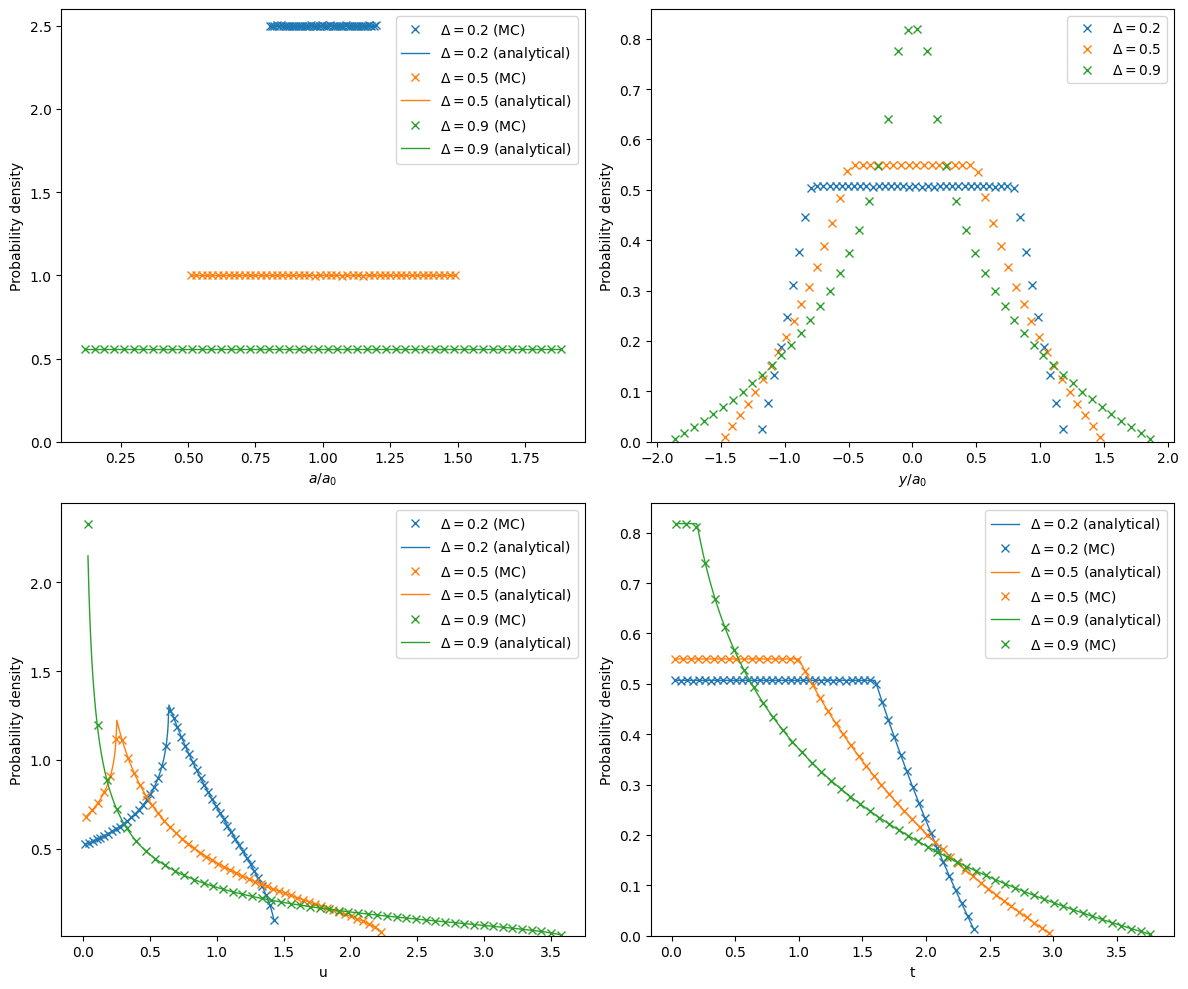

In [6]:
plt.figure(figsize=(12, 10))

# Subplot 1: Histogram for a/a₀
plt.subplot(2, 2, 1)
plt.plot(bins_a1, histo_a1, linestyle='', marker='x', markersize=6, color='#1f77b4', label=r'$\Delta = 0.2$ (MC)')
a_range = np.linspace(bins_a1[0], bins_a1[-1], 500)
p_anal = 0.5/deltas[0]*np.ones(500)
plt.plot(a_range, p_anal, '-', color='#1f77b4', linewidth=1, label=r'$\Delta = 0.2$ (analytical)')
plt.plot(bins_a2, histo_a2, linestyle='', marker='x', markersize=6, color='#ff7f0e', label=r'$\Delta = 0.5$ (MC)')
a_range = np.linspace(bins_a2[0], bins_a2[-1], 500)
p_anal = 0.5/deltas[1]*np.ones(500)
plt.plot(a_range, p_anal, '-', color='#ff7f0e', linewidth=1, label=r'$\Delta = 0.5$ (analytical)')
plt.plot(bins_a3, histo_a3, linestyle='', marker='x', markersize=6, color='#2ca02c', label=r'$\Delta = 0.9$ (MC)')
a_range = np.linspace(bins_a3[0], bins_a3[-1], 500)
p_anal = 0.5/deltas[2]*np.ones(500)
plt.plot(a_range, p_anal, '-', color='#2ca02c', linewidth=1, label=r'$\Delta = 0.9$ (analytical)')
plt.xlabel(r'$a/a_{0}$')
plt.ylabel('Probability density')
plt.ylim(bottom=0)
plt.legend()

# Subplot 2: Histogram for y/a₀
plt.subplot(2, 2, 2)
plt.plot(bins_y1, histo_y1, linestyle='', marker='x', markersize=6, color='#1f77b4', label=r'$\Delta = 0.2$')
plt.plot(bins_y2, histo_y2, linestyle='', marker='x', markersize=6, color='#ff7f0e', label=r'$\Delta = 0.5$')
plt.plot(bins_y3, histo_y3, linestyle='', marker='x', markersize=6, color='#2ca02c', label=r'$\Delta = 0.9$')
plt.xlabel(r'$y/a_{0}$')
plt.ylabel('Probability density')
plt.ylim(bottom=0)
plt.legend()

# Subplot 3: Histogram for u (instead of v)
plt.subplot(2, 2, 3)
plt.plot(bins_v1, histo_v1, linestyle='', marker='x', markersize=6, color='#1f77b4', label=r'$\Delta = 0.2$ (MC)')
v_range = np.linspace(bins_v1[0], bins_v1[-1], 500)
p_anal = (1/(4*deltas[0]*np.sqrt(v_range))) * ( np.heaviside((1-deltas[0])**2 - v_range, 1) * ( np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[0]), -1, 1)) - np.arccos(np.clip(np.sqrt(v_range)/(1-deltas[0]), -1, 1)) ) + np.heaviside(v_range - (1-deltas[0])**2, 1) * np.heaviside((1+deltas[0])**2 - v_range, 1) * np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[0]), -1, 1)) )
plt.plot(v_range, p_anal, '-', color='#1f77b4', linewidth=1, label=r'$\Delta = 0.2$ (analytical)')
plt.plot(bins_v2, histo_v2, linestyle='', marker='x', markersize=6, color='#ff7f0e', label=r'$\Delta = 0.5$ (MC)')
v_range = np.linspace(bins_v2[0], bins_v2[-1], 500)
p_anal = (1/(4*deltas[1]*np.sqrt(v_range))) * ( np.heaviside((1-deltas[1])**2 - v_range, 1) * ( np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[1]), -1, 1)) - np.arccos(np.clip(np.sqrt(v_range)/(1-deltas[1]), -1, 1)) ) + np.heaviside(v_range - (1-deltas[1])**2, 1) * np.heaviside((1+deltas[1])**2 - v_range, 1) * np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[1]), -1, 1)) )
plt.plot(v_range, p_anal, '-', color='#ff7f0e', linewidth=1, label=r'$\Delta = 0.5$ (analytical)')
plt.plot(bins_v3, histo_v3, linestyle='', marker='x', markersize=6, color='#2ca02c', label=r'$\Delta = 0.9$ (MC)')
v_range = np.linspace(bins_v3[0], bins_v3[-1], 500)
p_anal = (1/(4*deltas[2]*np.sqrt(v_range))) * ( np.heaviside((1-deltas[2])**2 - v_range, 1) * ( np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[2]), -1, 1)) - np.arccos(np.clip(np.sqrt(v_range)/(1-deltas[2]), -1, 1)) ) + np.heaviside(v_range - (1-deltas[2])**2, 1) * np.heaviside((1+deltas[2])**2 - v_range, 1) * np.arccos(np.clip(np.sqrt(v_range)/(1+deltas[2]), -1, 1)) )
plt.plot(v_range, p_anal, '-', color='#2ca02c', linewidth=1, label=r'$\Delta = 0.9$ (analytical)')
plt.xlabel('u')
plt.ylabel('Probability density')
plt.ylim(bottom=0.01)
plt.legend()

# Subplot 4: Histogram for t (instead of s)
plt.subplot(2, 2, 4)
s_range = np.linspace(bins_s1[0], bins_s1[-1], 500)
p_anal = (1/(4*deltas[0])) * np.log((1 + deltas[0])/(1 - deltas[0])) * np.heaviside(s_range, 1)*np.heaviside(2*(1 - deltas[0]) - s_range, 1) + (1/(4*deltas[0])) * np.log((2*(1 + deltas[0]))/s_range) * np.heaviside(s_range - 2*(1 - deltas[0]), 1)*np.heaviside(2*(1 + deltas[0]) - s_range, 1)
plt.plot(s_range, p_anal, '-', color='#1f77b4', linewidth=1, label=r'$\Delta = 0.2$ (analytical)')
plt.plot(bins_s1, histo_s1, linestyle='', marker='x', markersize=6, color='#1f77b4', label=r'$\Delta = 0.2$ (MC)')
s_range = np.linspace(bins_s2[0], bins_s2[-1], 500)
p_anal = (1/(4*deltas[1])) * np.log((1 + deltas[1])/(1 - deltas[1])) * np.heaviside(s_range, 1)*np.heaviside(2*(1 - deltas[1]) - s_range, 1) + (1/(4*deltas[1])) * np.log((2*(1 + deltas[1]))/s_range) * np.heaviside(s_range - 2*(1 - deltas[1]), 1)*np.heaviside(2*(1 + deltas[1]) - s_range, 1)
plt.plot(s_range, p_anal, '-', color='#ff7f0e', linewidth=1, label=r'$\Delta = 0.5$ (analytical)')
plt.plot(bins_s2, histo_s2, linestyle='', marker='x', markersize=6, color='#ff7f0e', label=r'$\Delta = 0.5$ (MC)')
s_range = np.linspace(bins_s3[0], bins_s3[-1], 500)
p_anal = (1/(4*deltas[2])) * np.log((1 + deltas[2])/(1 - deltas[2])) * np.heaviside(s_range, 1)*np.heaviside(2*(1 - deltas[2]) - s_range, 1) + (1/(4*deltas[2])) * np.log((2*(1 + deltas[2]))/s_range) * np.heaviside(s_range - 2*(1 - deltas[2]), 1)*np.heaviside(2*(1 + deltas[2]) - s_range, 1)
plt.plot(s_range, p_anal, '-', color='#2ca02c', linewidth=1, label=r'$\Delta = 0.9$ (analytical)')
plt.plot(bins_s3, histo_s3, linestyle='', marker='x', markersize=6, color='#2ca02c', label=r'$\Delta = 0.9$ (MC)')
plt.xlabel('t')
plt.ylabel('Probability density')
plt.ylim(bottom=0)
plt.legend()

plt.tight_layout()

fig = plt.gcf()             # Obtiene la figura actual
plt.draw()                  # Actualiza el renderer
renderer = fig.canvas.get_renderer()
axes = fig.get_axes()

for i, ax in enumerate(axes, start=1):
    bbox = ax.get_tightbbox(renderer)
    # Transforma el bounding box a coordenadas en pulgadas
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"subplot_{i}.pdf", bbox_inches=bbox_inches, dpi=300)

plt.savefig("plot_total.pdf", dpi=300)

plt.show()




### Visualización del histograma 2D normalizado (v vs s)

Se utiliza `pcolormesh` para graficar la matriz del histograma normalizado en escala logarítmica en ambos ejes.

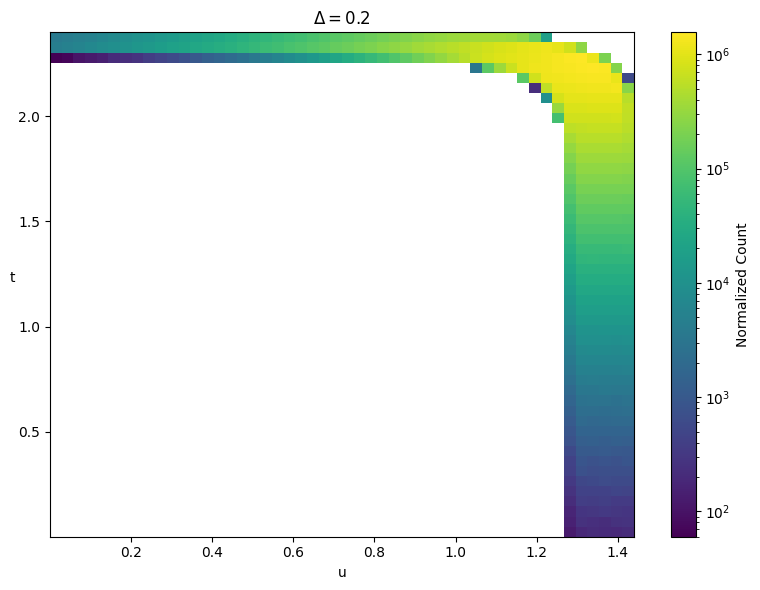

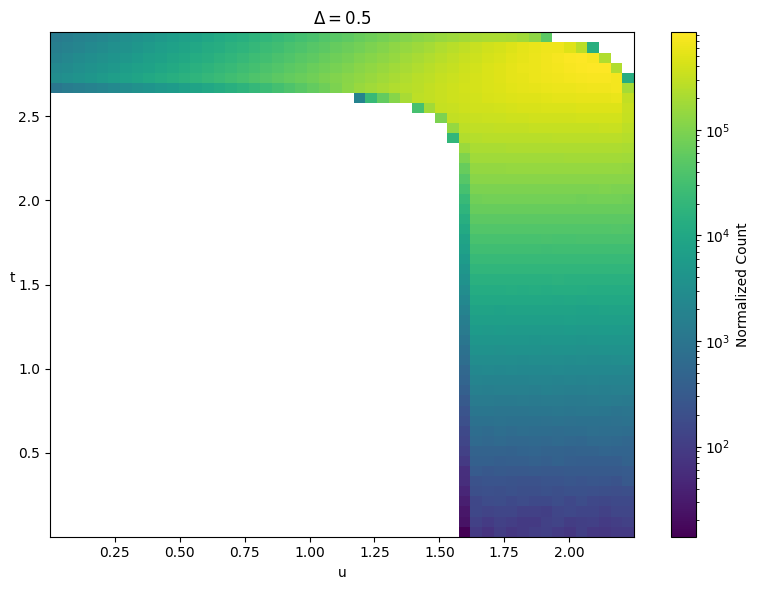

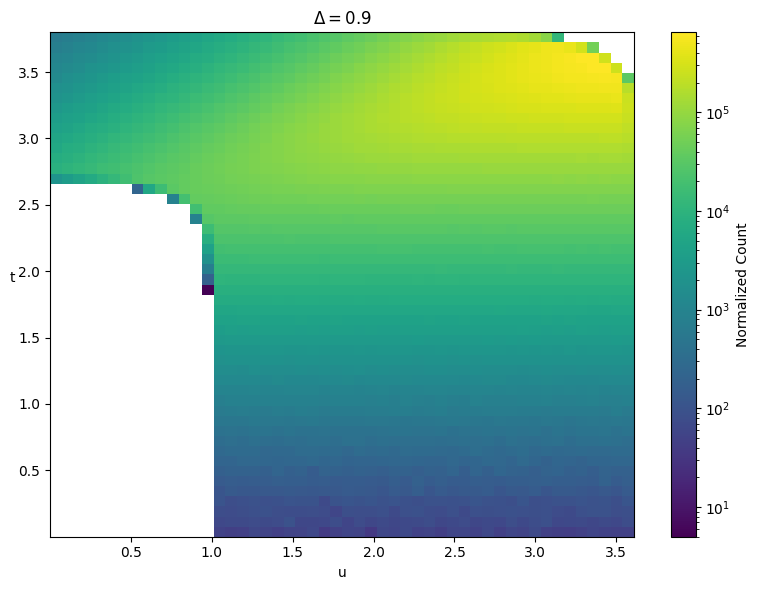

In [7]:
plt.figure(figsize=(8,6))
H_norm = H[0].copy()
plt.pcolormesh(bins_v1, bins_s1, H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.2$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
H_norm = H[1].copy()
plt.pcolormesh(bins_v2, bins_s2, H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.5$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
H_norm = H[2].copy()
plt.pcolormesh(bins_v3, bins_s3, H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.9$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.tight_layout()
plt.show()


### Average shear given v

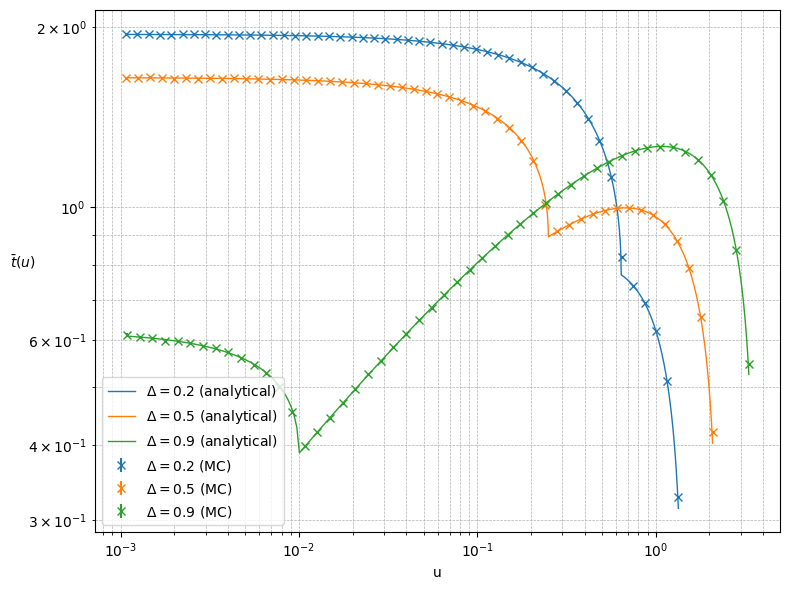

In [14]:
plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c' ]
for i in range(0,3):
    v_range = np.linspace(v_centers[i][0], v_centers[i][-1], 10000)
    p_anal = (
    # Tramo 1: 0 <= u <= (1 - Δ)^2 
    (2*np.sqrt(v_range)*np.log((1 + deltas[i])/(1 - deltas[i])) /
     (np.arccos(np.clip(np.sqrt(v_range)/(1 + deltas[i]), -1, 1)) -
      np.arccos(np.clip(np.sqrt(v_range)/(1 - deltas[i]), -1, 1))))
    * np.heaviside(v_range, 1)*np.heaviside((1 - deltas[i])**2 - v_range, 1)
    +
    # Tramo 2: (1 - Δ)^2 < u <= (1 + Δ)^2 
    (np.sqrt(v_range)/np.arccos(np.clip(np.sqrt(v_range)/(1 + deltas[i]), -1, 1))
     * np.log(((1 + deltas[i])**2)/v_range))
    * np.heaviside(v_range - (1 - deltas[i])**2, 1)
    * np.heaviside((1 + deltas[i])**2 - v_range, 1)
    )
    plt.plot(v_range, p_anal, '-', color=colors[i], linewidth=1, label=r'$\Delta =' + str(deltas[i]) + '$ (analytical)')
    plt.errorbar(v_centers[i], shear_given_v[i], yerr=sh_error_given_v[i], linestyle='', marker='x', markersize=6, color=colors[i], label=r'$\Delta =' + str(deltas[i]) + '$ (MC)') 
    

plt.xlabel('u')
plt.ylabel(r'$\bar{t}(u)$', rotation=0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
